In [1]:
import numpy as np
import xarray as xr
import xrft as xf
import dask.array as dsar
import os.path as op
import scipy.fftpack as fft

from matplotlib import colors
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def synthetic_field(N=512, dL=1., amp=1e1, s=-3.):
    """
    Generate a synthetic series of size N by N 
    with a spectral slope of s.
    """

    k = fft.fftshift(fft.fftfreq(N, dL))
    l = fft.fftshift(fft.fftfreq(N, dL))
    kk, ll = np.meshgrid(k, l)
    K = np.sqrt(kk**2+ll**2)

    ########
    # amplitude
    ########
    r_kl = np.ma.masked_invalid(np.sqrt(amp*.5*(np.pi)**(-1)*K**(s-1.))).filled(0.)
    #r = np.ma.masked_invalid(np.abs(k)**(-slope/2.)).filled(0.)
    ########
    # phase
    ########
    phi = np.zeros((N, N))
    
    N_2 = int(N/2)
    phi_upper_right = 2.*np.pi*np.random.random((N_2-1, 
                                                 N_2-1)) - np.pi
    phi[N_2+1:,N_2+1:] = phi_upper_right.copy()
    phi[1:N_2, 1:N_2] = -phi_upper_right[::-1, ::-1].copy()


    phi_upper_left = 2.*np.pi*np.random.random((N_2-1, 
                                                N_2-1)) - np.pi
    phi[N_2+1:,1:N_2] = phi_upper_left.copy()
    phi[1:N_2, N_2+1:] = -phi_upper_left[::-1, ::-1].copy()


    phi_upper_middle = 2.*np.pi*np.random.random(N_2) - np.pi
    phi[N_2:, N_2] = phi_upper_middle.copy()
    phi[1:N_2, N_2] = -phi_upper_middle[1:][::-1].copy()


    phi_right_middle = 2.*np.pi*np.random.random(N_2-1) - np.pi
    phi[N_2, N_2+1:] = phi_right_middle.copy()
    phi[N_2, 1:N_2] = -phi_right_middle[::-1].copy()


    phi_edge_upperleft = 2.*np.pi*np.random.random(N_2) - np.pi
    phi[N_2:, 0] = phi_edge_upperleft.copy()
    phi[1:N_2, 0] = -phi_edge_upperleft[1:][::-1].copy()


    phi_bot_right = 2.*np.pi*np.random.random(N_2) - np.pi
    phi[0, N_2:] = phi_bot_right.copy()
    phi[0, 1:N_2] = -phi_bot_right[1:][::-1].copy()


    phi_corner_leftbot = 2.*np.pi*np.random.random() - np.pi


#     print(phi[N/2-1,N-1], phi[N/2+1,1])
#     print(phi[N/2+1,N/2+1], phi[N/2-1,N/2-1])


#     phi[:N/2, :] = -np.rot90(np.rot90(phi[N/2:, :]))
#     phi[:N/2, :] = -phi[N/2:, :][::-1,::-1]
#     i, j = 25, 40
#     print(phi[N/2+j,N/2+i], -phi[N/2-j,N/2-i])

    for i in range(1, N_2):
        for j in range(1, N_2):
            assert (phi[N_2+j, N_2+i] == -phi[N_2-j, N_2-i])
        
    for i in range(1, N_2):
        for j in range(1, N_2):
            assert (phi[N_2+j, N_2-i] == -phi[N_2-j, N_2+i])
        
    for i in range(1, N_2):
        assert (phi[N_2, N-i] == -phi[N_2, i])
        assert (phi[N-i, N_2] == -phi[i, N_2])
        assert (phi[N-i, 0] == -phi[i, 0])
        assert (phi[0, i] == -phi[0, N-i])
    #########
    # complex fourier amplitudes
    #########
    #a = r + 1j*th
    F_theta = r_kl * np.exp(1j * phi)
    
    # check that symmetry of FT is satisfied
    #np.testing.assert_almost_equal(a[1:N/2], a[-1:-N/2:-1].conj())

    theta = fft.ifft2(fft.ifftshift(F_theta))
    return np.real(theta) 

In [3]:
def fit_loglog(x, y):
    # fig log vs log
    p = np.polyfit(np.log2(x), np.log2(y), 1)
    y_fit = 2**(np.log2(x)*p[0] + p[1])
    #A = np.vstack([np.log2(x), np.ones(len(x))]).T
    #a, b = np.linalg.lstsq(A, np.log2(y))[0]
    #y_fit = 2**(np.log2(x)*a + b)
    
    return y_fit, p[0]

In [4]:
theta = synthetic_field(N=512, s=-3.)
print(theta.shape)
theta = xr.DataArray(theta, dims=['k', 'l'],
            coords={'k':range(512), 'l':range(512)})
# theta = dsar.from_array(theta, chunks=(32, 32))
theta

(512, 512)


/Users/uchidatakaya/anaconda/envs/xrft/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in power
  from ipykernel import kernelapp as app


<xarray.DataArray (k: 512, l: 512)>
array([[-4.350836, -4.448019, -4.532209, ..., -4.21469 , -4.233558, -4.297065],
       [-4.404343, -4.482409, -4.521904, ..., -4.227213, -4.268786, -4.309178],
       [-4.434264, -4.520036, -4.579518, ..., -4.27612 , -4.298753, -4.328494],
       ..., 
       [-4.37518 , -4.356597, -4.372262, ..., -4.237948, -4.272185, -4.316958],
       [-4.365693, -4.377853, -4.410534, ..., -4.274198, -4.311229, -4.350105],
       [-4.342774, -4.388914, -4.451836, ..., -4.240266, -4.268186, -4.332117]])
Coordinates:
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * l        (l) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...

In [5]:
f, iso_f = xf.dft(theta, remove_mean=True, 
                  density=True, iso=True)

/Users/uchidatakaya/anaconda/envs/xrft/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: pandas.core.common.is_timedelta64_dtype is deprecated. import from the public API: pandas.api.types.is_timedelta64_dtype instead
  
/Users/uchidatakaya/Documents/Python/xrft/xrft/xrft.py:106: RuntimeWarning: invalid value encountered in true_divide
  weights=K.ravel()) / area)
/Users/uchidatakaya/Documents/Python/xrft/xrft/xrft.py:110: RuntimeWarning: invalid value encountered in true_divide
  / area) * kr


In [13]:
f

<xarray.DataArray (freq_k: 512, freq_l: 512)>
array([[ 661424.051853     +0.j      , -606358.972929+270632.177743j,
        -403289.480385-530781.156278j, ...,  585377.518358+324328.963172j,
        -403289.480385+530781.156278j, -606358.972929-270632.177742j],
       [ 196507.812194+634269.390265j,  666620.098967  +1533.722943j,
         406700.592085-531486.972753j, ...,  508289.459415+439377.014727j,
         667273.268980 -51285.069116j,   63060.433564-663632.49647j ],
       [-312824.976915+588652.33769j , -197421.454177-639459.571231j,
         648321.409749+176362.351825j, ..., -625886.484487+251513.383339j,
        -224721.448924+633186.070499j,  183460.284947-643603.99133j ],
       ..., 
       [-666478.861325 -60514.814375j, -483483.232629+466534.349636j,
         421054.619758+526978.064669j, ..., -225401.145603-638590.810522j,
         670681.357171 +71967.983197j, -568909.102068+357425.193862j],
       [-312824.976915-588652.33769j ,  183460.284947+643603.99133j ,
       

In [8]:
iso_f

<xarray.DataArray (freq_kr: 65)>
array([           nan,   4.594070e+18,   8.834236e+16,   1.511592e+16,
         5.383429e+15,   2.485355e+15,   1.350785e+15,   8.110852e+14,
         5.274405e+14,   3.618812e+14,   2.586467e+14,   1.922234e+14,
         1.462398e+14,   1.136669e+14,   9.017611e+13,   7.285576e+13,
         5.970239e+13,   4.943762e+13,   4.143017e+13,   3.507294e+13,
         2.995691e+13,   2.578705e+13,   2.233860e+13,   1.946060e+13,
         1.705904e+13,   1.505829e+13,   1.335919e+13,   1.189850e+13,
         1.064334e+13,   9.564972e+12,   8.629616e+12,   7.805449e+12,
         7.084011e+12,   6.451129e+12,   5.889886e+12,   5.392739e+12,
         4.951816e+12,   4.556917e+12,   4.200947e+12,   3.881484e+12,
         3.595536e+12,   3.335454e+12,   3.099718e+12,   2.884926e+12,
         2.689356e+12,   2.512678e+12,   2.350342e+12,   2.201767e+12,
         2.065497e+12,   1.940148e+12,   1.825275e+12,   1.719086e+12,
         1.620794e+12,   1.529927e+12,   1.4

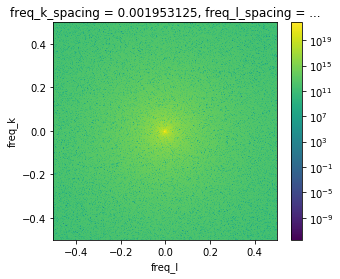

In [7]:
fig = plt.figure(figsize=(11,4))

ax1 = fig.add_subplot(121)
(f.real**2).plot(norm=colors.LogNorm())
# (f*np.conj(f)).real().plot(norm=colors.LogNorm())

# ax2 = fig.add_subplot(122)
# ax2.loglog(iso_f)

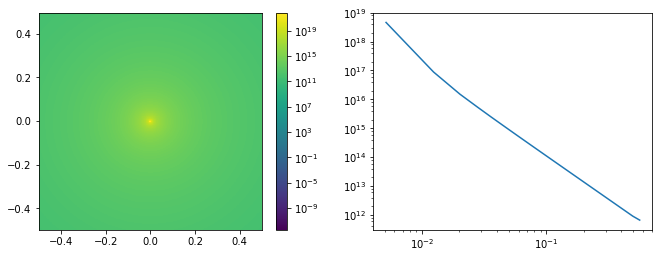

In [15]:
fig = plt.figure(figsize=(11,4))

ax1 = fig.add_subplot(121)
im = ax1.pcolormesh(f.freq_k.values, f.freq_l.values, 
               (f.values*np.conj(f.values)).real, 
               norm=colors.LogNorm())
cbar = fig.colorbar(im)
# (f*np.conj(f)).real().plot(norm=colors.LogNorm())

ax2 = fig.add_subplot(122)
ax2.loglog(iso_f.freq_kr.values, iso_f.values)